# Employment Recommender Systems 
## Using Natural Language Processing

## Script 1 - Preprocessing

By Erik Konstenius, Danielle Duncan, Muhammed Azkaenza and Elias Aslaksen

In [1]:
!pip install -r requirements.txt

In [10]:
# Import pacakages
import re
import os
import copy
import gdown
import shutil
import operator
import textract
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from colorama import Fore
from wordcloud import WordCloud
from IPython.core.display import display, HTML
from top2vec import Top2Vec
from textwrap import fill
from langdetect import detect
from pdfminer.high_level import extract_text

# gensim
import gensim
import gensim.downloader as api
from gensim.models import TfidfModel, CoherenceModel, Nmf, LdaMulticore
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation,strip_numeric
from gensim.corpora.dictionary import Dictionary

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import *

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [7]:
nltk.download('stopwords', 'punkt', 'wordnet', 'omw-1.4')
pd.options.display.max_colwidth = 2000 # increase dataframe column size to fit text better
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

## Download and Load dataset

### Get the dataset:
##### Download manually:
- Download the dataset from google drive with this link:                                    
https://drive.google.com/drive/folders/1mWKlOg1z5Le6QrXbYJ4yGld4h6Dhrp0-?usp=sharing
- Save them in the same folder as this jupyter notebook file

##### OR use code as below:

In [11]:
# download files from google drive folder with gdown
# url = "https://drive.google.com/drive/folders/1mWKlOg1z5Le6QrXbYJ4yGld4h6Dhrp0-?usp=sharing"
# gdown.download_folder(url, quiet=True, use_cookies=False)

# unzip job_data.zip, job listing dataset scraped from LinkedIn.com
shutil.unpack_archive('job_data.zip')

## Path

In [12]:
job_path = 'job_data'
cv_path = 'software_development.pdf'

# Resume Input

In [13]:
#Instead of using NLTKs stopwords list we used a list that has been made via NLTK's github community to try
#and remove as much non-essential information as possible. We also added our own words that we felt were 
#unique to processing resumes like month words and "experience"

manual_stopwords = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",'request','fluent','international',     'experience',     'available','mission',    'ability', 'regional', 'contact','january','february','march','april','may','june','july','august','september','october','november', 'december',]

long_stopwords=[]

for word in manual_stopwords:
    if len(word)> 3:
        long_stopwords.append(word)
long_stopwords = list(set(long_stopwords))

print(long_stopwords[0:20])

['amongst', 'readily', 'whereas', 'becomes', 'show', 'myself', 'towards', 'considering', 'strongly', 'respectively', 'thereupon', 'wasn', 'twelve', 'move', 'needn', 'greetings', 'somewhere', 'necessarily', "you've", 'provides']


In [14]:
def upload_resume (resume_file_path_pdf):
    
    # check file, must be a pdf
    ext = os.path.splitext(resume_file_path_pdf)[-1].lower()
    if ext != ".pdf":
        raise Exception("Your file must be a PDF to be processed")
    
    # extract the resume from pdf to text
    resume = extract_text(resume_file_path_pdf)
    
    # check resume language
    resume_lang = detect(resume)
    if resume_lang != "en":
        raise Exception("The uploaded resume must be in english.")
    
    #Tokenizing the resume
    tokenized_resume = nltk.word_tokenize(resume)
    print("Word count with no processing:", len(tokenized_resume))
    
    #initializing lemmetizer function
    lemmatizer = WordNetLemmatizer()
    
    #List with resumes that have been cleaned
    cleaned_resume=[]
 
    #Looping through the tokenized resume and if words are alphanumeric and longer than 3 characters,
    #They are put as lowercase and lemmatized and then put in the clean resume list
    for word in tokenized_resume:
        if word.isalpha():
            if len(word) > 3:
                lower_word = word.lower()
                lemma_word = lemmatizer.lemmatize(lower_word)
                cleaned_resume.append(lemma_word)

    print("Word count after removing chars, short words, and lemmatizing", len(cleaned_resume))
    resume = []

    for word in cleaned_resume:
        if word not in long_stopwords:
            resume.append(word)

    print("Word count after removing stop words and identified words", len(resume))

    return resume

In [15]:
resume = upload_resume(cv_path)

Word count with no processing: 401
Word count after removing chars, short words, and lemmatizing 229
Word count after removing stop words and identified words 202


In [16]:
resume

['elliot',
 'alderson',
 'software',
 'developer',
 'main',
 'francisco',
 'united',
 'state',
 'rozenboomchantal',
 'nationality',
 'francisco',
 'driving',
 'license',
 'passionate',
 'software',
 'engineer',
 'year',
 'professional',
 'building',
 'application',
 'proficient',
 'development',
 'stack',
 'birth',
 'place',
 'birth',
 'profile',
 'employment',
 'history',
 'software',
 'developer',
 'johnson',
 'johnson',
 'francisco',
 'software',
 'developer',
 'unlimited',
 'francisco',
 'johnson',
 'johnson',
 'fortune',
 'medical',
 'device',
 'manufacturing',
 'company',
 'software',
 'developer',
 'work',
 'ecommerce',
 'platform',
 'agile',
 'environment',
 'daily',
 'responsibility',
 'include',
 'participating',
 'daily',
 'stand',
 'meeting',
 'scrum',
 'master',
 'utilizing',
 'stack',
 'enhance',
 'maintain',
 'ecommerce',
 'platform',
 'conducting',
 'code',
 'peer',
 'review',
 'member',
 'team',
 'participating',
 'product',
 'demo',
 'documenting',
 'code',
 'change',

In [17]:
# save clean resume_data

with open('resume_data.txt', 'w') as filehandle:
    for listitem in resume:
        filehandle.write('%s\n' % listitem)

# Information Retrieval

## EDA

### Creating a Dataset

In [18]:
# each excel files of jobs within each location are uploaded to a folder '/work/linkedin_webscraping'

# create data frame of all jobs from all locations
doc_list = os.listdir(job_path)
df = pd.DataFrame()

for xlsx in doc_list:
     df = df.append(pd.read_excel(job_path+"/"+xlsx),ignore_index=True)

# view dataset
df

,Title,Image,basecard__fulllink_URL,hiddennestedlink_URL,hiddennestedlink,Location,resultbenefits__text,Date,Label,Text,seniority_level,employment_type,job_function,industries
0,English Teacher,https://media-exp1.licdn.com/dms/image/C4D0BAQG7mwATzoy5jg/company-logo_100_100/0/1519927599113?e=1660176000&v=beta&t=duH--XReCTx_aSg7lF-HazyW_eMSbmuyL-fFUnjcpVY,https://at.linkedin.com/jobs/view/english-teacher-at-english-in-action-3030488290?refId=IZVWxoPcH4ZW09ywwjLvhg%3D%3D&trackingId=xqnktbIxRi7mM8xk%2FH21AA%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card,https://www.linkedin.com/company/english-in-action?trk=public_jobs_jserp-result_job-search-card-subtitle,English in Action,"Vienna, Austria",NaN,2022-04-20,Apply Now,English in Action is looking for qualified English teachers (PGCE or TEFL) for immediate start in delivering 1 week English Project weeks in schools around Europe (predominantly Austria and Germany). We offer short term flexible contracts from 1-6 weeks at a time with good rates of pay and accomodation + travel expenses covered. Contact recruitment@englishinaction.com with your CV attached.,NaN,Contract,NaN,NaN
1,Office Assistant,https://media-exp1.licdn.com/dms/image/C4D0BAQHCa3YDvCfOUQ/company-logo_100_100/0/1579859019943?e=1660176000&v=beta&t=beiZ1q9mBYrwPBWHQls5WmUlMh13jHrZfgUSLocTQ_Y,https://at.linkedin.com/jobs/view/office-assistant-at-bambinifashion-com-3050923993?refId=IZVWxoPcH4ZW09ywwjLvhg%3D%3D&trackingId=AwCn0rdM%2B4W%2Fcdal7E2T0Q%3D%3D&position=2&pageNum=0&trk=public_jobs_jserp-result_search-card,https://at.linkedin.com/company/bambinifashion?trk=public_jobs_jserp-result_job-search-card-subtitle,BAMBINIFASHION.COM,"Vienna, Austria",Actively Hiring,2022-04-29,Apply Now,"WHO WE ARE\n\nBAMBINIFASHION.COM is one of Europe’s premier children’s luxury outfitters and lifestyle brands. Our rich collections have been carefully curated from the most prestigious designers to create a highly personalised service that appeals to both parents and their children. We are champions of self-expression and individuality, providing daily style inspiration for little ones, gift ideas & much more!\n\nWe are a company with an entrepreneurial spirit and innovative culture. Our goal is to grow from global player to E-Commerce leader in the children’s luxury fashion space.\n\n \n\nYOUR RESPONSIBILITIES:\n\nPerform clerical duties, including, but not limited to, mailing and filing correspondence, placing orders, and answering calls\nInteract with clients, visitors, and vendors\nArrange meetings by reserving rooms and managing refreshments\nPhotocopies, scans, and files appropriate documents\nEdit documents for accuracy\nAssist with organising events when necessary\nMaintain accurate records and enters data\nSign for delivered packages and distributes them to the appropriate recipient\nCover reception upon occasion\nMaintain stock of supplies by anticipating work requirements, ordering supplies, and distributing supplies where necessary\nPerform additional duties when required, including drafting brochures and organising the filing system\n\n \n\nABOUT YOU:\n\nVALID WORK PERMIT FOR AUSTRIA\nFlexibility, precise work and willingness to perform\n38,5 hours per week, full time\n\n \n\nStudents with a student visa can also apply for 20 hours per week.\n\n \n\nThe gross full-time basis salary is as stated in the Collective Agreement.\n\nPlease send an updated CV (including examples of relevant previous work) to office@bambinifashion.com",NaN,Full-time,NaN,NaN
2,Recruiter at Central European University,https://media-exp1.licdn.com/dms/image/C4D0BAQHigW_IbFLSBA/company-logo_100_100/0/1615285336384?e=1660176000&v=beta&t=o8DCkNL1fH-Z61XFV70BabrjTyhEQlMotk9S-3didf4,https://at.linkedin.com/jobs/view/recruiter-at-central-european-university-at-join-solutions-ag-3063711067?refId=IZVWxoPcH4ZW09ywwjLvhg%3D%3D&trackingId=7UFFD1MquEP%2FaES9w17srQ%3D%3D&position=3&pageNum=0&trk=public_jobs_jserp-result_search-card,https://de.linke

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21880 entries, 0 to 21879
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Title                   21880 non-null  object
 1   Image                   19014 non-null  object
 2   basecard__fulllink_URL  19715 non-null  object
 3   hiddennestedlink_URL    19715 non-null  object
 4   hiddennestedlink        19715 non-null  object
 5   Location                21880 non-null  object
 6   resultbenefits__text    20856 non-null  object
 7   Date                    21880 non-null  object
 8   Label                   7854 non-null   object
 9   Text                    19394 non-null  object
 10  seniority_level         14285 non-null  object
 11  employment_type         18366 non-null  object
 12  job_function            14268 non-null  object
 13  industries              14244 non-null  object
dtypes: object(14)
memory usage: 2.3+ MB


In [20]:
# split "Location" column into 2 columns -> "City" and "Country"
df['Country'] = df['Location'].apply(lambda x: x.split(',')[-1])
df['City'] = df['Location'].apply(lambda x: x.split(',')[0])

# removing whitespace
for column in list(df.columns):
    df[column] = df[column].str.strip()

# rename columns
df.rename(columns={
    'Title': 'Position',
    'Image': 'Logotype', 
    'basecard__fulllink_URL': 'Link', 
    'hiddennestedlink_URL': 'Link2',
    'hiddennestedlink': 'Company',
    'resultbenefits__text': 'Status_1',
    'Label': 'Status_2',
    'Text': 'Description',
    'seniority_level': 'Seniority_level',
    'employment_type': 'Employment_type',
    'job_function': 'Department',
    'industries': 'Industry',
}, errors="raise", inplace=True)

### Investigating nulls

In [21]:
print("Number of rows in dataset: " + str(df.shape[0]))
print("Number of columns in dataset: " + str(df.shape[1]))
print("Number of nulls in dataset: " + str(df.isna().sum().sum()))

Number of rows in dataset: 21880
Number of columns in dataset: 16
Number of nulls in dataset: 56352


In [2]:
df.isna().sum()[df.isna().sum()>0].sort_values().plot(kind='bar')
plt.title("Number of nulls per column")

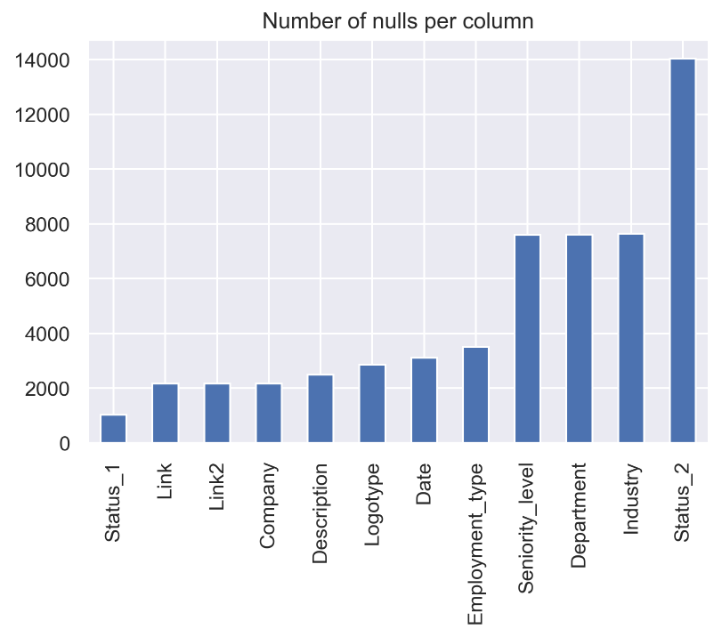

In [3]:
# visualize distribution of nulls in dataset. Useful to investigate the consistency in web scraper
msno.matrix(df)

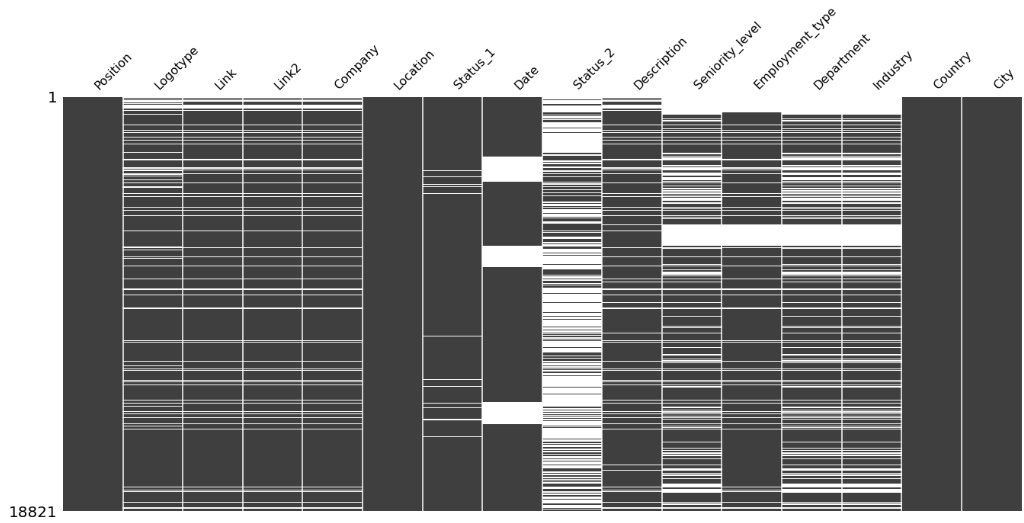

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21880 entries, 0 to 21879
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Position         21880 non-null  object
 1   Logotype         19014 non-null  object
 2   Link             19715 non-null  object
 3   Link2            19715 non-null  object
 4   Company          19715 non-null  object
 5   Location         21880 non-null  object
 6   Status_1         20856 non-null  object
 7   Date             18782 non-null  object
 8   Status_2         7854 non-null   object
 9   Description      19394 non-null  object
 10  Seniority_level  14285 non-null  object
 11  Employment_type  18366 non-null  object
 12  Department       14268 non-null  object
 13  Industry         14244 non-null  object
 14  Country          21880 non-null  object
 15  City             21880 non-null  object
dtypes: object(16)
memory usage: 2.7+ MB


In [25]:
# dropping unused columns
columns_drop = ['Logotype', 'Link2', 'Location', 'Status_1', 'Status_2']
df.drop(columns=columns_drop, inplace=True)

# dropping rows without "Description"
df.dropna(subset=['Description'], inplace=True)

# dropping rows which have 'Description' duplicates
df.drop_duplicates(subset='Description', keep='first', inplace=True)

In [4]:
print("After dropping unused columns and all rows without Description")
print("Number of rows in dataset: " + str(df.shape[0]))
print("Number of columns in dataset: " + str(df.shape[1]))
print("Number of nulls in dataset: " + str(df.isna().sum().sum()))

figure(figsize=(8, 6), dpi=80)

df.isna().sum()[df.isna().sum()>0].sort_values().plot(kind='bar')
plt.title("Number of nulls per column")

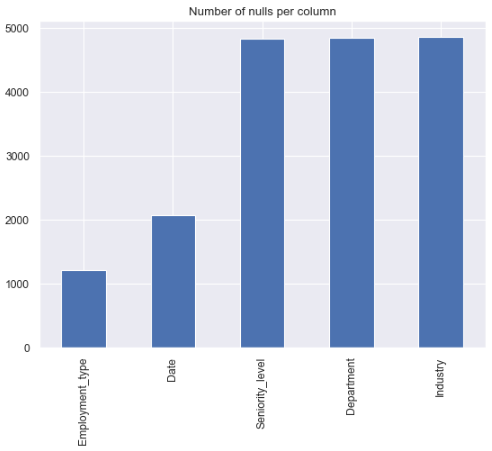

### Distribution of categorical features

<AxesSubplot:title={'center':'Country'}>

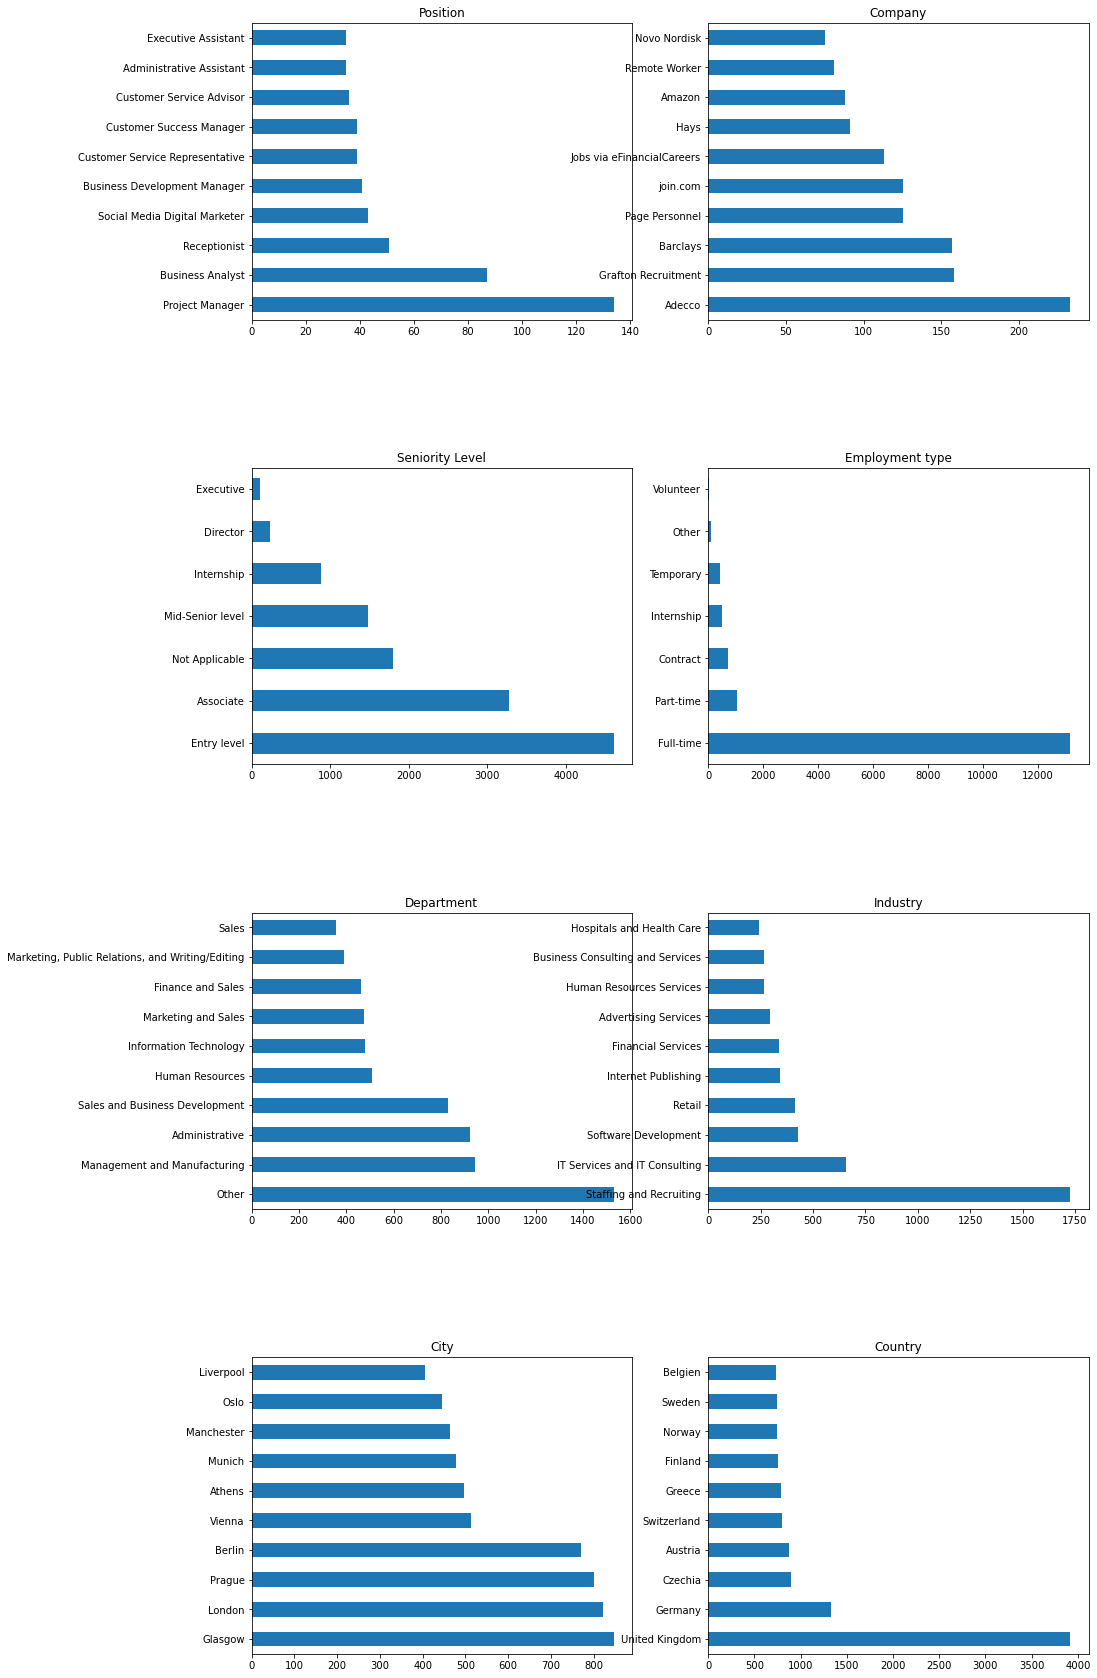

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_figheight(30)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=.5)

df['Position'].value_counts().sort_values().nlargest(n=10).plot(kind='barh', title='Position',ax=axes[0,0])
df['Company'].value_counts().sort_values().nlargest(n=10).plot(kind='barh', title='Company', ax=axes[0,1])
df['Seniority_level'].value_counts().sort_values().nlargest(n=10).plot(kind='barh', title='Seniority Level', ax=axes[1,0])
df['Employment_type'].value_counts().sort_values().nlargest(n=10).plot(kind='barh', title='Employment type', ax=axes[1,1])
df['Department'].value_counts().sort_values().nlargest(n=10).plot(kind='barh', title='Department', ax=axes[2,0])
df['Industry'].value_counts().sort_values().nlargest(n=10).plot(kind='barh', title='Industry', ax=axes[2,1])
df['City'].value_counts().sort_values().nlargest(n=10).plot(kind='barh', title='City', ax=axes[3,0])
df['Country'].value_counts().sort_values().nlargest(n=10).plot(kind='barh', title='Country', ax=axes[3,1])

### Job descriptions

In [28]:
print("Average length of job description: " + str(round(df['Description'].str.len().mean())) + " words")

Average length of job description: 2884 words


In [29]:
for index, row in df[0:50].iterrows():
    print(Fore.RED + row['Position'])
    print(Fore.WHITE + row['Description'])

English Teacher
English in Action is looking for qualified English teachers (PGCE or TEFL) for immediate start in delivering 1 week English Project weeks in schools around Europe (predominantly Austria and Germany). We offer short term flexible contracts from 1-6 weeks at a time with good rates of pay and accomodation + travel expenses covered. Contact recruitment@englishinaction.com with your CV attached.
Office Assistant
WHO WE ARE

BAMBINIFASHION.COM is one of Europe’s premier children’s luxury outfitters and lifestyle brands. Our rich collections have been carefully curated from the most prestigious designers to create a highly personalised service that appeals to both parents and their children. We are champions of self-expression and individuality, providing daily style inspiration for little ones, gift ideas & much more!

We are a company with an entrepreneurial spirit and innovative culture. Our goal is to grow from global player to E-Commerce leader in the children’s luxury fa

## Preprocessing

### Cleaning job descriptions

In [30]:
# phrases that are often found in section that we are not interested in

word_list = ['please submit','submit your application','for more information', 'send your application', 
    'please don’t hesitate','please don’t hesitate','we also offer','we offer','about us',
    'what do we offer','is a leading','what’s in it for you','applications will','how to apply',
    'equal opportunity employer','equal opportunities employer','sexual orientation','gender',
    'religion','disability','ancestry','inclusive','about the department','for further information',
    ' cv ','applications will be','please read more','please let us know','please contact',
    'privacy policy','fast-growing company','our offices','growth opportunities',
    'equal opportunity workplace','we are committed','is proud to be','by submitting your application',
    'we look forward']

In [31]:
def description_cleaner(df):
    
    # create function to detect language of the text in the descriptions column
    def detect_languages(df):
        list_of_languages = []

        for description in list(df['Description'].astype(str)):
            list_of_languages.append(detect(description))

        df["Language"] = list_of_languages
    
    # remove non-english descriptions 
    detect_languages(df)
    print("Removing  " + str((~df["Language"].str.contains('en')).sum()) + " non-english descriptions")
    df.drop(df[df.Language != 'en'].index, inplace=True)
    
    # Remove all rows where description is missing
    print("Removing " + str(df['Description'].isna().sum()) + " jobs from dataset due to missing descriptions")
    df = df[df['Description'].notna()]

    # convert each newline character in the job descriptions to punctuations. This creates 
    # better tokens when we sentence tokenize.
    df['Description'] = df['Description'].replace('\n','.', regex=True)

    # sentence tokenize descriptions
    for index, row in df.iterrows():
        row['Description'] = sent_tokenize(row['Description'])

    # If phrase in string then remove sentence. We remove these sentences to 
    clean_descriptions = []
    for description in df['Description']:
        temp = []
        for sentence in description:
            if any(substring in sentence.lower() for substring in word_list):
                pass 
            else:
                temp.append(str(sentence)) # keep the sentence if the substring was not found in sentence
        clean_descriptions.append(temp) # add the cleaned description together with all other descriptions
    
    # remove sentence tokenization of each descriptions
    temp = []
    for description in clean_descriptions:
        temp.append(' '.join(str(i) for i in description)) 

    df['Clean_description'] = temp # add the new column to the dataframe

    df['Position'] = df['Position'].str.replace(r' ?- ?.*| in.*|\([^)]*\)| with.*|\d|\s+$', '')
    
    # remove stop words
    stop_words = manual_stopwords
    df["Clean_description"] = df["Clean_description"].apply(
        lambda x: ' '.join([word for word in str(x).split() if word not in (stop_words)]))

    rows = []
    for row in df["Clean_description"]:
        clean_row = re.sub('www.[^ ]+', '', row) # remove URLs
        clean_row = re.sub('https?://[^ ]+', '', clean_row) # remove URLs 
        clean_row = (re.sub('[^A-Za-z0-9-" "]+', ' ', clean_row)) # remove special characters
        clean_row = clean_row.lower() # lower case
        rows.append(re.sub(r'\b\w{1,2}\b', '', clean_row)) # remove short words
    df["Clean_description"] = rows
    
    df["Clean_description"] = df["Clean_description"].str.strip() # remove whitespace
    df = df[df['Clean_description'].notna()] # remove nulls
    
    return df

In [33]:
# cleaned the description (Runtime: 4-5 min)
data = description_cleaner(df) 

Removing  3881 non-english descriptions
Removing 0 jobs from dataset due to missing descriptions


C:\Users\MUHAMM~1\AppData\Local\Temp/ipykernel_19572/1273310934.py:47: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Position'] = df['Position'].str.replace(r' ?- ?.*| in.*|\([^)]*\)| with.*|\d|\s+$', '')


### Cleaning Assessment 

In [34]:
print("Average length of job description: " + str(round(data['Clean_description'].str.len().mean())) + " words")

Average length of job description: 1711 words


The length of the average description has decreased from 2898 to 1711 words, about 41% due our method to remove irrelevant sections in the descriptions.

In [35]:
for index, row in data.iterrows():
    print(Fore.RED + row['Position'])
    print(Fore.WHITE + row['Clean_description'])

English Teacher
english action qualified english teachers  pgce tefl  start delivering  week english project weeks schools europe  predominantly austria germany
Office Assistant
who  are bambinifashion com europe  premier children  luxury outfitters lifestyle brands  our rich collections carefully curated prestigious designers create highly personalised service appeals parents children   champions self-expression individuality  providing daily style inspiration ones  gift ideas   more  company entrepreneurial spirit innovative culture  our goal grow global player -commerce leader children  luxury fashion space   your responsibilities perform clerical duties  including  limited   mailing filing correspondence  placing orders  answering calls interact clients  visitors  vendors arrange meetings reserving rooms managing refreshments photocopies  scans  files documents edit documents accuracy assist organising events necessary maintain accurate records enters data sign delivered packages d

sales manager -     sales manager pro-active commercial team  specifically  responsible performing tasks highest standards analyse local market trends competitor activity identify business leads sales research   conduct pro-active projects specific markets hotelligence tools disposal  agency 360  thepec  miceview hunt accounts daily sales calls  external   telemarketing develop customer accounts travel domestic markets drive business hotel increase market share revenue streams negotiate room rates packages corporate clients prepare company contracts hotel current business pricing conditions work current business strategies recognising potential opportunities cooperate departments hotel create exceptional guest build strong  comprehensive sales programs attend sales events participate hotel promotional activities required produce accurate timely reports meet senior management include reporting appointments  calls business leads answer customer queries prompt professional manner conduct 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executive Assistant EN/GER/FR
presentation  market leader  ems sets standards design  manufacturing sale devices medical dental treatments  ems products benefit tradition flawless swiss precision craftsmanship founded  years ago  ems offers valuable solutions fields  dental prevention   inventors guided biofilm therapy  evidence-based protocol biofilm management teeth  soft tissues implants original airflow  perioflow  piezon  technologies urology   market leaders endoscopic lithotripsy  ems shapes history future stone management lithoclast  laserclast  product range shock wave therapy - inventors rswt   radial eswt  developers swiss dolorclast  method effective treatment muscular-skeletal pathologies dermatological conditions respect  excellence client orientation ems core values quality ems dna  engraved ems mission happy healthy patients  successful clinicians  passionate partners  ems mission  ems delivers innovative clinically proven treatment outcomes invasive way  this quote    

In [36]:
# save clean job_data

data.to_excel("clean_data.xlsx")  